In [7]:
# Ensure notebook is being run from base repository directory
import os, sys
try:
#     os.chdir("/home/{}/forecast_rodeo_ii".format(os.environ["USER"]))
    os.chdir("/Users/quetzal/content/covid-ensembles/covid19-forecast-hub")
except Exception as err:
    print(f"Warning: unable to change directory; {repr(err)}")
from src.utils.notebook_util import isnotebook
if isnotebook():
    # Autoreload packages that are modified
    %load_ext autoreload
    %autoreload 2
else:
    from argparse import ArgumentParser
    
# Computational libraries 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy.matlib
from collections import deque

# os libraries 
import shutil
from datetime import datetime, timedelta
from functools import partial
import copy
import pdb
import os

from utils import *
from file_util import *
from attributes import *

from zoo_of_experts import *
from zoo_of_hinters import *
from zoo_of_losses import *


import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#
# Specify model parameters
#
model_name = "online_expert" 

if not isnotebook():
    # If notebook run as a script, parse command-line arguments
    parser = ArgumentParser()
    parser.add_argument("pos_vars",nargs="*")  # gt_id and horizon 
    
    parser.add_argument('--target_dates', '-t', default="std_future")
    parser.add_argument('--reg', '-r', default="entropic",
                       help='Regularization type, one of: <quadratic>, <entropic> <orig>, <opt_delay>, <plusplus>')
    parser.add_argument('--alg', '-a', default="adahedgefo",
                       help='Online learning algorithm. One of: <ftl>, <ftrl>, <adahedgefo>, <adahedgesr>, <flip_flop>, <rm>, <rmplus>.')
    parser.add_argument('--hint', '-hi', default="None",
                       help='Optimistic hints, only used with adahedgefo. One of: <None>, <doy>, <prev_y>, <trend_y>, <prev_z>, <mean_z>.')  
    parser.add_argument('--delay', '-d', default=0,
                       help='Delay parameter, number of experts to instantiate. String containting an integer >=0.')      
    parser.add_argument('--exp_name', '-e', default="None",
                       help='Experiment name prefix, use "None" if not running an experiment to use standard submodel name.')
    parser.add_argument('--location', '-l', default="US",
                       help='Experimental location, a two character state abbrevaition or "US".')  
    parser.add_argument('--quantile', '-q', default=0.5,
                       help='Prediction quantile. Default to 0.5 for median prediction".')      
    args, opt = parser.parse_known_args()
    
    # Assign variables                                                                                                                                     
    gt_id = get_id_name(args.pos_vars[0]) # "contest_precip" or "contest_tmp2m"                                                                            
    horizon = get_th_name(args.pos_vars[1]) # "34w" or "56w"    
    target_date_str = args.target_dates # target date object
    location = args.location # target date object
    quantile = args.quantile
    alg = args.alg # algorithm 
    reg = args.reg # algorithm regularization 
    hint_type = args.hint # type of optimistic hint
    delay_param = int(args.delay) # delay parameter     
    exp_name = args.exp_name # name of experiment, to be prepended to submodel name
else:
    # Otherwise, specify arguments interactively
    gt_id = "incd_case" #"contest_precip", "contest_tmp2m"    
    horizon = "1w"    
    target_date_str = "std_weekly" #"contest_precip", "contest_tmp2m"
    location = 'US'
    quantile = 0.5
    alg = 'rmplus' # 'ftl', ftrl', 'adahedgefo', 'adahedgesr', 'flip_flop', 'rm', 'rmplus'
    reg = "None" # 'quadratic', 'entropic'    
    hint_type = "None"
    delay_param = 0
    exp_name = "None" # Set experiment name, use "None" if not running an experiment
    
'''
Adaptive hinting parameters
'''
hint_alg = 'rmplus' # 'ftl', ftrl', 'adahedgefo', 'adahedgesr', 'flip_flop', 'rm', 'rmplus'
hint_reg = "None"

In [9]:
"""
Read in ground truth and model predictions for task
"""
# Get location FIPS codes
fips_codes = get_fips_codes() 

# Read ground truth dataframe
printf(f'Loading {gt_id} ground truth')
df_gt = get_ground_truth(gt_id, location, load_df=True)

# Get target dates for which ground truth is avalible, inclusive
first_date, last_date = get_data_range(gt_id, location=location)
printf(f"Getting target dates from {first_date} to {last_date}.")

# Get target dates between first and last date inclusive
target_dates = get_target_dates(target_date_str, first_date, last_date)
target_date_objs = pd.Series(target_dates)

# Store delta between target date and forecast issuance date.
# Accounts for the fact that predictions can be made up to Monday for
# what will happen on EW Satuday.
start_delta = timedelta(days=get_start_delta(horizon, gt_id))

# Get model predicitons for the task; use load_df to use previously
# compiled dataframe if avalible. Otherwise, generated fresh dataframe
# from data source.
printf(f'Loading model predictions for {gt_id}, {horizon}, {location}, q{quantile}')
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)

display(model_pred_df)
# Get list of persistant models; models that have come online at some point
# and made predictions for the entire period. 
persistant_models, all_models, all_models_dates = get_persistant_models(model_pred_df)
expert_models = list(all_models)
expert_models.sort()
model_string = (',').join(expert_models)
persistant_index = dict(zip(all_models, range(len(all_models))))
printf(f"Predictions for models loaded:\n {expert_models}")

Loading incd_case ground truth
Getting target dates from 2020-01-29 00:00:00 to 2020-10-19 00:00:00.
Loading model predictions for incd_case, 1w, US, q0.5


value
model             location target_end_date              
COVIDhub-baseline US       2020-04-11       1.873670e+05
                           2020-04-18       2.175430e+05
                           2020-04-25       2.058010e+05
                           2020-05-02       2.101950e+05
                           2020-05-09       1.943850e+05
...                                                  ...
JCB-PRM           US       2020-11-21       1.002619e+06
JHUAPL-Bucky      US       2020-11-21       1.201568e+06
UMich-RidgeTfReg  US       2020-11-21       1.298949e+06
COVIDhub-ensemble US       2020-11-21       1.136360e+06
LANL-GrowthRate   US       2020-11-21       1.269858e+06

[440 rows x 1 columns]

Predictions for models loaded:
 ['BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline', 'COVIDhub-ensemble', 'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon', 'CovidAnalytics-DELPHI', 'DDS-NBDS', 'IowaStateLW-STEM', 'JCB-PRM', 'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'OliverWyman-Navigator', 'RobertWalraven-ESG', 'UCF-AEM', 'UCLA-SuEIR', 'UChicagoCHATTOPADHYAY-UnIT', 'UMich-RidgeTfReg', 'USACE-ERDC_SEIR', 'USC-SI_kJalpha', 'UVA-Ensemble']


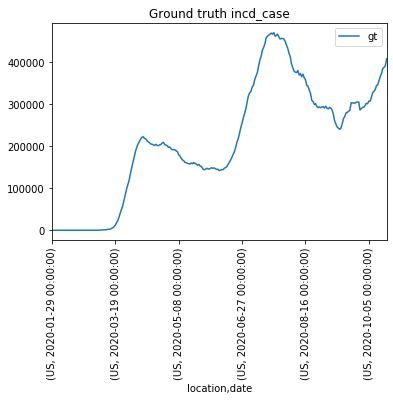

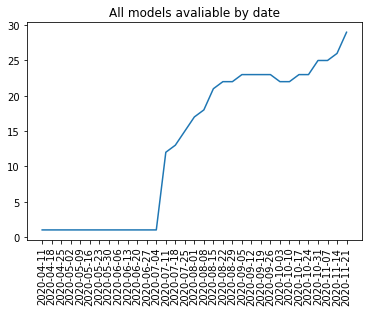

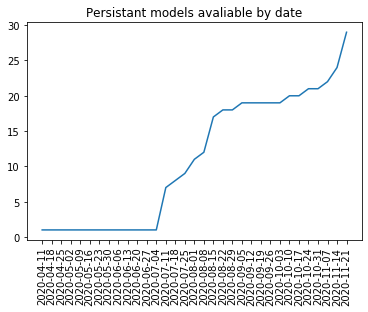

In [10]:
"""
Visualize ground truth 
"""
df_gt.plot()
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()

"""
Visualize avalible models
"""
plt.plot(list(all_models_dates.keys())[::-1], [len(x) for x in all_models_dates.values()][::-1])
plt.xticks(rotation=90)
plt.title('All models avaliable by date')
plt.show()

"""
Visualize persistant models
"""
plt.plot(list(persistant_models.keys())[::-1], [len(x) for x in persistant_models.values()][::-1])
plt.xticks(rotation=90)
plt.title('Persistant models avaliable by date')
plt.show()

In [11]:
"""
Set up online learning parameterization
"""
# Record submodel name for the online expert model
submodel_name = get_submodel_name(
    expert_models=model_string, 
    reg=reg, 
    alg=alg, 
    hint = hint_type,
    delay=delay_param,
    training_dates=target_date_str,
    exp_name=exp_name)

printf(f"Submodel name {submodel_name}")

if not isnotebook():
    # TODO: need to set this up
    # Save output to log file
    logger = start_logger(model=model_name,submodel=submodel_name,gt_id=gt_id,
                          horizon=horizon,target_dates=target_date_str)
    # Store parameter values in log                                                                                                                        
    params_names = ['gt_id', 'horizon', 'target_date_str',
                    'model_string', 'alg',
                    'reg', 'reset_quarters', 'hint_type',
                    'delay_param', 'exp_name']
    params_values = [eval(param) for param in params_names]
    log_params(params_names, params_values)  

Submodel name online_expert-rmplus_regNone_D0_None_std_weekly_allmodels


In [19]:
'''
Instantiate loss
'''
rodeo_loss = MAELoss()
hint_loss = HintingLossTwoNorm()


''' Duration '''
duration = len(target_date_objs)
active_experts = np.zeros((len(expert_models),), dtype=bool)
''' 
Instantiate prototype online learner
'''

# Instantiate expert
num_experts = delay_param + 1
oe = get_expert(alg=alg, loss=rodeo_loss, T=duration//num_experts, 
                expert_list=expert_models, init_method="uniform", reg=reg, active_experts=active_experts)  
printf(f"-initializing online_expert for with duration {duration//num_experts}")   

'''
Instantiate hint generator
'''
if alg == "rm" or alg == "rmplus":
    regret_hints = True # Provide pseudo-regret hints
else:
    regret_hints = False # Provide cummulative gradient hints

# TODO: delay horizon 
# In order, list of 1 day hints, 12w hints, 34w hint, future hints, etc.
horizon_hints = [[hint_type], 
                 [hint_type],
                 [hint_type],
                 [hint_type]]    
    
n_hints = [sum(len(x) for x in horizon_hints)]
hint_models = [item + str(i) for i, sublist in enumerate(horizon_hints) for item in sublist]
hint_partition = [i for i, sublist in enumerate(horizon_hints) for item in sublist]

# Initialize 
printf(f"-initializing joint hinter of type {hint_models}")   
hinter = JointHinter(gt_id, horizon_hints, oe, regret_hints)

'''
Instantiate prototype online hinter
'''
oh = get_expert(alg=hint_alg, loss=hint_loss, T=duration//num_experts, 
                expert_list=hint_models, init_method="uniform", reg=hint_reg,
                partition=hint_partition) 

printf(f"-initializing online_expert for with duration {duration//num_experts}")  



# Store losses
forecast = pd.Series(index=target_date_objs, dtype='float64')
losses = pd.Series(index=target_date_objs, dtype='float64')
regret_gt = pd.DataFrame(columns=expert_models, index=target_date_objs, dtype='float64')
regret_gt.fillna(0, inplace=True) # Fill with zeros

online_params = None
online_hint_params = None
hint_pred_df = None
expert_pred_df = pd.DataFrame(index=target_date_objs, columns=expert_models)
expert_pred_df = expert_pred_df.fillna(0)

'''
Initialize online experts
'''
ei = 0
experts_dates = {}
hinters_dates = {}
experts_queue = [None]*(num_experts)
hinters_queue = [None]*(num_experts)
for e in range(num_experts):
    experts_dates[e] = []    
    hinters_dates[e] = []      
    hinters_queue[e] = copy.deepcopy(oh)        
    experts_queue[e] = copy.deepcopy(oe)    
      
'''
Perform online prediction
'''
for target_date_obj in target_date_objs:
    printf(f"\n\n\t----- Starting {target_date_obj}") 
    
    # Convert target date to string
    date_str = datetime.strftime(target_date_obj, '%Y-%m-%d')  
    
    """
    Get the set of active, persistant models
    """
    if date_str not in persistant_models:
        printf(f'Skipping target. No persistant models avalible.')
        continue
        
    active_models = persistant_models[date_str]
    active_ind = [persistant_index[x] for x in active_models]
    printf(f"There are {len(active_models)} avalible models {active_models} at index {active_ind}")
        
    tic()
    # Get value of current prediction
    pred_cur = model_pred_df.loc[(model_pred_df.index.get_level_values('target_end_date') == date_str)]
    # Get active models
    pred_cur = pred_cur[pred_cur.index.get_level_values("model").isin(active_models)].droplevel([1,2])
    expert_pred_df.loc[target_date_obj, active_models] = pred_cur.value
    toc()
            
    '''
    Get an avalible expert to make a prediction for target dates. 
    '''
    cur_oe = experts_queue[ei]
    cur_oh = hinters_queue[ei] 
    
    # Update parameter logging
    params = cur_oe.log_params()
    hint_params = cur_oh.log_params()            
    
    # Update parameter set for dates in target range
    if online_params is None:                                                
         online_params = pd.DataFrame(params, index=[target_date_obj])        
    else:                                                                    
        online_params.loc[target_date_obj] = copy.copy(params)
        
    if online_hint_params is None:                                                
         online_hint_params = pd.DataFrame(hint_params, index=[target_date_obj])        
    else:                                                                    
        online_hint_params.loc[target_date_obj] = copy.copy(hint_params)          
    '''
    Update model weights with previously avaliable ground truth; use current 
    prediction to provide optimistic hint, if necessary.
    '''
    pred = None # Initialize prediction
    printf(f"Making target prediction {target_date_obj} using expert {ei} with experience {cur_oe.t}.")  
    
    # Add current target date to outstanding predictions
    experts_dates[ei].append(target_date_obj)

    last_data_date = target_date_obj - start_delta
    printf(f"--Last data date {last_data_date}")

    # Get expert prediction dates that are avalible for updates
    update_dates = [x for x in experts_dates[ei] if x <= last_data_date]
    if len(update_dates) > 1:
        raise ValueError(f"Warning: more than one date in the update queue {len(update_dates)}")

    for date in update_dates:
        dstr = datetime.strftime(date, '%Y-%m-%d')  
        expert_pred = expert_pred_df.loc[date]
        hinter_pred = hint_pred_df.loc[(hint_pred_df.index.get_level_values('target_date') == date)]
        
        if df_gt.index.get_level_values("date").isin([dstr]).any():   
            printf(f"Updating expert {ei} w/{cur_oe.t} experience with forecast on {target_date_obj}.")
            printf(f"--Outstanding expert predictions: {len(experts_dates[ei])} for expert {ei}")   
            
            d = experts_dates[ei].pop(0) # Remove prediction to be updated from outstanding predictions

            # Check that that oustanding prediction is correct
            if d != date: raise ValueError(f"Bad date {d} != {date}")
            
            ''' Set values of experts without predictions to zero'''
            # Ground truth
            gt_val = float(df_gt[df_gt.index.get_level_values("date") == dstr]['gt'])
            
            ''' Get loss gradient '''      
            grad = cur_oe.loss_gradient(
                     X=expert_pred.to_numpy(copy=False), 
                     y=gt_val,
                     w=online_params.loc[date][expert_models].to_numpy(copy=False))

            ''' Update regret ground truth '''
            r = cur_oe.loss_regret(g=grad, w=online_params.loc[date][expert_models].to_numpy(copy=False))
            regret_gt.loc[date, expert_models] = r
               

            ''' Get hint value '''  
            hinter.update_hint_data(g_fb=grad, y_fb=gt_val)  
            
            H = hinter.get_hint_matrix(
                        X_all=expert_pred_df,
                        y_all=df_gt,
                        w_all=online_params[expert_models],
                        last_data_date=last_data_date,
                        os_preds=experts_dates[ei])

            ''' Get hint weights '''
            hint = cur_oh.update_and_predict(
                         X_cur=H,
                         X_fb=hint_pred_df.loc[date].to_numpy(copy=False).T, 
                         y_fb=regret_gt.loc[experts_dates[ei], :].to_numpy(copy=False).sum(axis=0),
                         w_fb=online_hint_params.loc[date, hint_models].to_numpy(copy=False))
            printf(f"Hint: {hint}")  
            
            ''' Get prediction for target date '''
            pred = cur_oe.update_and_predict(
                         X_cur=expert_pred_df.loc[target_date_obj].to_numpy(copy=False),
                         active_ind=active_ind,
                         hint=hint,
                         X_fb=expert_pred.to_numpy(copy=False), 
                         y_fb=gt_val,
                         w_fb=online_params.loc[date][expert_models].to_numpy(copy=False))

            # Remove updated date; TODO may not need this
            expert_pred_df.drop(date, inplace=True)    
                
    # If no data was avaliable for predict and update, make a prediction without feedback
    if pred is None:
        # Before the first feedback
        H = hinter.get_hint_matrix(
                        X_all=expert_pred_df,
                        y_all=df_gt,
                        w_all=online_params[expert_models],       
                        last_data_date=last_data_date,
                        os_preds=experts_dates[ei])
        
        hint = cur_oh.update_and_predict(X_cur=H)        
        # printf(f"Hint grad sum: {hint}")
        '''
        Get prediction for target date without feedback
        '''
        pred = cur_oe.update_and_predict(
                     X_cur=expert_pred_df.loc[target_date_obj].to_numpy(copy=False),
                     active_ind=active_ind,            
                     hint=hint)
    '''
    Update hinting historical parameters
    '''
    index = pd.MultiIndex.from_arrays(
        [[target_date_obj]*len(hint_models), hint_models], 
        names=('target_date', 'hint'))
    
    if hint_pred_df is None:
        hint_pred_df = pd.DataFrame(H.T, columns=expert_models, index=index)        
    else:
        df = pd.DataFrame(H.T, columns=expert_models, index=index)                
        hint_pred_df = pd.merge(hint_pred_df, df, on=expert_models,
                         left_index=True, right_index=True, how='outer')
        
    '''
    Mark the current expert as busy until delay_delta days before gt is avalible
    '''
    # Add expert with key providing the next target date for which the expert can make predictions
    ei = (ei+1) % num_experts
    '''
    Save forecasts and update metric logging
    '''
    params = cur_oe.log_params()
    hint_params = cur_oh.log_params()    
    printf(f"-alg params:\n{params}\n")
    printf(f"-hint params:\n{hint_params}\n")        

    # Update parameter set for dates in target range
    if online_params is None:                                                
         online_params = pd.DataFrame(params, index=[target_date_obj])        
    else:                                                                    
        online_params.loc[target_date_obj] = params.values()
    if online_hint_params is None:                                                
         online_hint_params = pd.DataFrame(hint_params, index=[target_date_obj])        
    else:                                                                    
        online_hint_params.loc[target_date_obj] = hint_params.values()        
    
    # Save forecast
    forecast.loc[target_date_obj] = pred
    
    # Skip dates without forecast outputs
    if not df_gt.index.get_level_values("date").isin([date_str]).any():
        printf(f"warning: some features unavailable for target={target_date_obj}; skipping evalution.")
        printf("-mean loss: {}, running score: {}".format(mean_loss, mean_loss_to_score(mean_loss)))        
        printf("-loss: {}, score: {}".format(loss, mean_loss_to_score(loss)))        
    else: 
        # Evaluate and store error
        gt_val = float(df_gt[df_gt.index.get_level_values("date") == date_str]['gt'])
        loss = cur_oe.loss(gt_val, pred)
        losses.loc[target_date_obj] = loss
        printf("-loss: {}".format(loss))
        mean_loss = losses.mean()
        printf("-mean loss: {}".format(mean_loss))
        
               
# Save losses in standard format
losses = losses.reset_index()
losses.columns = ['target_date','loss']

# Get output directory and create if it doesn't exist
output_folder = get_task_metrics_dir(model=model_name, 
                                     submodel=submodel_name, 
                                     gt_id=gt_id, 
                                     horizon=horizon)
make_directories(output_folder)
metric_file_path = f'{output_folder}/loss-{gt_id}_{horizon}-{target_date_str}.h5'
pandas2hdf(losses, metric_file_path)


# Log online learning parameters to file
logdir = get_task_forecast_dir(model=model_name, 
                               submodel=submodel_name,
                               gt_id=gt_id, 
                               horizon=horizon)
make_directories(logdir)
file_path = f'{output_folder}/forecast-{gt_id}_{horizon}-{target_date_str}.h5'
pandas2hdf(forecast, file_path)

param_file_path = f'{logdir}/learning_params-{gt_id}_{horizon}-{target_date_str}.h5'
pandas2hdf(online_params, param_file_path)

hint_param_file_path = f'{logdir}/hint_params-{gt_id}_{horizon}-{target_date_str}.h5'
pandas2hdf(online_hint_params, hint_param_file_path)

-initializing online_expert for with duration 38
-initializing joint hinter of type ['None0', 'None1', 'None2', 'None3']
-initializing online_expert for with duration 38


	----- Starting 2020-02-01 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-02-08 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-02-15 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-02-22 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-02-29 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-03-07 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-03-14 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-03-21 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-03-28 00:00:00
Skipping target. No persistant models avalible.


	----- Starting 2020-04-04 00:00:00
Skipping target. N


-hint params:
{'t': 7, 'None0': 1.0, 'None1': 1.0, 'None2': 1.0, 'None3': 1.0}

-loss: 18365.0
-mean loss: 16596.666666666668


	----- Starting 2020-05-23 00:00:00
There are 1 avalible models ['COVIDhub-baseline'] at index [2]
-elapsed time: 0.00327 (s)
Making target prediction 2020-05-23 00:00:00 using expert 0 with experience 7.
--Last data date 2020-05-18 00:00:00
Updating expert 0 w/7 experience with forecast on 2020-05-23 00:00:00.
--Outstanding expert predictions: 2 for expert 0
Hint: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
-alg params:
{'t': 8, 'BPagano-RtDriven': 0.0, 'CEID-Walk': 0.0, 'COVIDhub-baseline': 1.0, 'COVIDhub-ensemble': 0.0, 'CU-nochange': 0.0, 'CU-scenario_high': 0.0, 'CU-scenario_low': 0.0, 'CU-scenario_mid': 0.0, 'CU-select': 0.0, 'Columbia_UNC-SurvCon': 0.0, 'CovidAnalytics-DELPHI': 0.0, 'DDS-NBDS': 0.0, 'IowaStateLW-STEM': 0.0, 'JCB-PRM': 0.0, 'JHUAPL-Bucky': 0.0, 'JHU_CSSE-DECOM': 0.0, 'JHU_IDD-CovidSP': 0.0, 

-alg params:
{'t': 14, 'BPagano-RtDriven': 0.0, 'CEID-Walk': 0.0, 'COVIDhub-baseline': 1.0, 'COVIDhub-ensemble': 0.0, 'CU-nochange': 0.0, 'CU-scenario_high': 0.0, 'CU-scenario_low': 0.0, 'CU-scenario_mid': 0.0, 'CU-select': 0.0, 'Columbia_UNC-SurvCon': 0.0, 'CovidAnalytics-DELPHI': 0.0, 'DDS-NBDS': 0.0, 'IowaStateLW-STEM': 0.0, 'JCB-PRM': 0.0, 'JHUAPL-Bucky': 0.0, 'JHU_CSSE-DECOM': 0.0, 'JHU_IDD-CovidSP': 0.0, 'Karlen-pypm': 0.0, 'LANL-GrowthRate': 0.0, 'LNQ-ens1': 0.0, 'OliverWyman-Navigator': 0.0, 'RobertWalraven-ESG': 0.0, 'UCF-AEM': 0.0, 'UCLA-SuEIR': 0.0, 'UChicagoCHATTOPADHYAY-UnIT': 0.0, 'UMich-RidgeTfReg': 0.0, 'USACE-ERDC_SEIR': 0.0, 'USC-SI_kJalpha': 0.0, 'UVA-Ensemble': 0.0}

-hint params:
{'t': 14, 'None0': 1.0, 'None1': 1.0, 'None2': 1.0, 'None3': 1.0}

-loss: 76063.0
-mean loss: 22787.23076923077


	----- Starting 2020-07-11 00:00:00
There are 7 avalible models ['COVIDhub-baseline', 'Columbia_UNC-SurvCon', 'CovidAnalytics-DELPHI', 'LANL-GrowthRate', 'OliverWyman-Navigator

-hint params:
{'t': 19, 'None0': 1.0, 'None1': 1.0, 'None2': 1.0, 'None3': 1.0}

-loss: 43044.397608590196
-mean loss: 24318.722004159503


	----- Starting 2020-08-15 00:00:00
There are 17 avalible models ['CEID-Walk', 'COVIDhub-baseline', 'COVIDhub-ensemble', 'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon', 'CovidAnalytics-DELPHI', 'DDS-NBDS', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'OliverWyman-Navigator', 'UCLA-SuEIR', 'UMich-RidgeTfReg'] at index [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 17, 18, 19, 20, 23, 25]
-elapsed time: 0.00984 (s)
Making target prediction 2020-08-15 00:00:00 using expert 0 with experience 19.
--Last data date 2020-08-10 00:00:00
Updating expert 0 w/19 experience with forecast on 2020-08-15 00:00:00.
--Outstanding expert predictions: 2 for expert 0
Hint: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
-alg params:
{'t': 20, 'BPagano-RtDriven': 0.0, 'CEID-Wal

-elapsed time: 0.00768 (s)
Making target prediction 2020-09-12 00:00:00 using expert 0 with experience 23.
--Last data date 2020-09-07 00:00:00
Updating expert 0 w/23 experience with forecast on 2020-09-12 00:00:00.
--Outstanding expert predictions: 2 for expert 0
Hint: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
-alg params:
{'t': 24, 'BPagano-RtDriven': 0.0, 'CEID-Walk': 0.09021043818166447, 'COVIDhub-baseline': 0.019158911164202215, 'COVIDhub-ensemble': 0.08489052863837526, 'CU-nochange': 0.08077319826740943, 'CU-scenario_high': 0.08055136717757058, 'CU-scenario_low': 0.07970403789623048, 'CU-scenario_mid': 0.08074623352259273, 'CU-select': 0.08045112250057909, 'Columbia_UNC-SurvCon': 0.03168288182396285, 'CovidAnalytics-DELPHI': 0.05443301585984358, 'DDS-NBDS': 0.11936563700106965, 'IowaStateLW-STEM': 0.026400467213181372, 'JCB-PRM': 0.0, 'JHUAPL-Bucky': 0.0, 'JHU_CSSE-DECOM': 0.0, 'JHU_IDD-CovidSP': 0.0, 'Karlen-pypm': 0.07092201874605

Hint: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
-alg params:
{'t': 28, 'BPagano-RtDriven': 0.0, 'CEID-Walk': 0.0936449561167717, 'COVIDhub-baseline': 0.025445354000080113, 'COVIDhub-ensemble': 0.08622583122356679, 'CU-nochange': 0.07239410615938456, 'CU-scenario_high': 0.07207747367401901, 'CU-scenario_low': 0.07110593756579865, 'CU-scenario_mid': 0.07198576689034833, 'CU-select': 0.07170379168883967, 'Columbia_UNC-SurvCon': 0.03369005123620911, 'CovidAnalytics-DELPHI': 0.01404814608522493, 'DDS-NBDS': 0.1251731041041369, 'IowaStateLW-STEM': 0.03328794475293657, 'JCB-PRM': 0.0, 'JHUAPL-Bucky': 0.01325766266940973, 'JHU_CSSE-DECOM': 0.0, 'JHU_IDD-CovidSP': 0.0, 'Karlen-pypm': 0.07344325273091362, 'LANL-GrowthRate': 0.06359924812999805, 'LNQ-ens1': 0.013815779357682701, 'OliverWyman-Navigator': 0.0250496055455575, 'RobertWalraven-ESG': 0.0, 'UCF-AEM': 0.0, 'UCLA-SuEIR': 0.012722645749694434, 'UChicagoCHATTOPADHYAY-UnIT': 0.0, 'UMich-RidgeTf

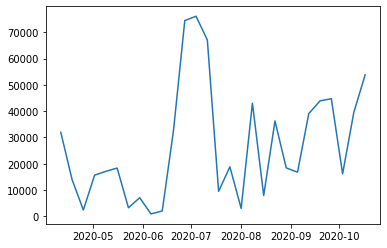

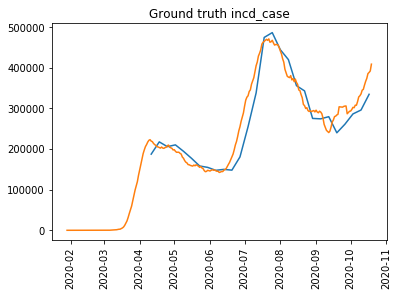

In [29]:
"""
Plot time-varying losses
"""
plt.plot(losses['target_date'], losses['loss'])
plt.show()
"""
Plot values
"""
gt_flat = df_gt.reset_index()
plt.plot(forecast)
plt.plot(gt_flat['date'], gt_flat['gt'])
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()